In [128]:
from scipy.integrate import odeint 
import time
import math
import numpy as np
import pylab as py
from math import *
import numpy as np
from scipy.optimize import newton
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from IPython.display import HTML
# import import_ipynb
# import Functions
import openpyxl

In [129]:
m1 = 2                 # mass of pendulum 1 (in kg)
m2 = 1                 # mass of pendulum 2 (in kg)
L1 = 1.4                 # length of pendulum 1 (in meter)
L2 = 1                 # length of pendulum 2 (in meter)
g = 9.8                # gravitatioanl acceleration constant (m/s^2)

In [130]:
tfinal = 125.0 
Nt = 3755
t = np.linspace(0, tfinal, Nt)
timestep = tfinal / Nt

In [131]:
# Differential equations describing the system
def double_pendulum(u,t,m1,m2,L1,L2,g):
    # du = derivatives
    # u = variables
    # p = parameters
    # t = time variable
    
    du = np.zeros(4)
    c = np.cos(u[0]-u[2])  # intermediate variables
    s = np.sin(u[0]-u[2])  # intermediate variables

    du[0] = u[1]   # d(theta 1)
    du[1] = ( m2*g*np.sin(u[2])*c - m2*s*(L1*c*u[1]**2 + L2*u[3]**2) - (m1+m2)*g*np.sin(u[0]) ) /( L1 *(m1+m2*s**2) )
    du[2] = u[3]   # d(theta 2)   
    du[3] = ((m1+m2)*(L1*u[1]**2*s - g*np.sin(u[2]) + g*np.sin(u[0])*c) + m2*L2*u[3]**2*s*c) / (L2 * (m1 + m2*s**2))
    
    return du


In [132]:
def makepath(theta1, theta2):
    u0 = [np.pi*theta1/180, 0, np.pi*theta2/180, 0]
    tfinal = 25.0       # Final time. Simulation time = 0 to tfinal.
    Nt = 751
    t = np.linspace(0, tfinal, Nt)
    sol = odeint(double_pendulum, u0, t, args=(m1,m2,L1,L2,g))
    return sol, t

We will take to solutions.  the first is from the stable region and the second is chaotic

In [133]:
class MyLSTM(nn.Module):
    def __init__(self, input_size = 4, hidden_layer_size = 100, num_layers = 1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, input_size)
        self.c_h = (torch.zeros(num_layers,1,hidden_layer_size),
                    torch.zeros(num_layers,1,hidden_layer_size))
    def forward(self, x):
        h, self.c_h= self.lstm(x.view(len(x) ,1, -1), self.c_h)
        predictions = self.linear(h.view(len(x), -1))
        return predictions[-1]

In [ ]:
use_saved_model = True
model = MyLSTM(input_size = 4, hidden_layer_size = 100, num_layers = 1)
filename = 'Datadriven_Benchmark_2002x1_one_init'
# filename = 'Energy_Conserv_2002x1_one_init'
# filename = 'Lagrange_2002x1_one_init'
if use_saved_model == True:
    model.load_state_dict(torch.load(filename))
                  
else:
    torch.save(model.state_dict(), filename)
    

C:\Users\lauto\AppData\Local\Temp\ipykernel_24776\1765230721.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


In [ ]:
#this is the full OneStep function.   it 
def OneStep(data, time, filename, steps = 1000):
    print('data set length =', len(data))
    train_window = 10
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_data_normalized = scaler.fit_transform(data.reshape(-1, 4))
    fut_pred = len(data) -train_window
    test_inputs = train_data_normalized[0:train_window].reshape(train_window,4).tolist()
    #print(test_inputs)
    s2 = train_data_normalized.reshape(len(data),4).tolist()
    realdata = data
    model.eval()
    preds = test_inputs.copy()
    t2 = test_inputs
    hidden_layer_size = 100
    x = 0
    for i in range(fut_pred):
        seq = torch.FloatTensor(t2[i:])
        model.c_h = (torch.zeros(1, 1, hidden_layer_size),
                        torch.zeros(1, 1, hidden_layer_size))
        x = model(seq)
        preds.append(x.detach().numpy())
        t2.append(x.detach().numpy())
    actual_predictions = scaler.inverse_transform(np.array(preds ).reshape(-1,4))
    print(len(actual_predictions))
    
    # the following will plot the lower mass path for steps using the actual ODE sover
    # and the predicitons
    plt.figure( figsize=(10,5))
    u0 = data[:,0]     # theta_1 
    u1 = data[:,1]     # omega 1
    u2 = data[:,2]     # theta_2 
    u3 = data[:,3]     # omega_2 
    up0 = actual_predictions[:,0]     # theta_1 
    up1 = actual_predictions[:,1]     # omega 1
    up2 = actual_predictions[:,2]     # theta_2 
    up3 = actual_predictions[:,3]     # omega_2 
    x1 = L1*np.sin(u0);          # First Pendulum
    y1 = -L1*np.cos(u0);
    x2 = x1 + L2*np.sin(u2);     # Second Pendulum
    y2 = y1 - L2*np.cos(u2);
    xp1 = L1*np.sin(up0);          # First Pendulum
    yp1 = -L1*np.cos(up0);
    xp2 = xp1 + L2*np.sin(up2);     # Second Pendulum
    yp2 = yp1 - L2*np.cos(up2);
    print(x2[0], y2[0])
    plt.plot(x2[0:steps], y2[0:steps], color='r')
    plt.plot(xp2[0:steps],yp2[0:steps] , color='g')
    err = 0.0
    errs = 0.0
    cnt = 0
    badday  =0.0
    errsq = 0.0
    maxerr = 0.0
    maxloc = 0
    
    #the following attempts to make an estimate of the error.  not very good.
    for i in range(len(actual_predictions)):
        er =np.linalg.norm(realdata[i]-actual_predictions[i])
        err += er
        if er > maxerr:
            maxerr = er
            maxloc = i
    print("mean error =", err/101)
    print('maxerr =', maxerr, ' at ', maxloc)
    
    # create dataframe
    df = pd.DataFrame({ 'time': time,
        f'theta1_actual': data[:, 0], 'omega1_actual': data[:, 1],
        'theta2_actual': data[:, 2], 'omega2_actual': data[:, 3],
        'theta1_predicted': actual_predictions[:, 0], 'omega1_predicted': actual_predictions[:, 1],
        'theta2_predicted': actual_predictions[:, 2], 'omega2_predicted': actual_predictions[:, 3]
    })
    
    # save as csv
    df.to_csv(f'test_{filename}.csv', index=False)
    
    return actual_predictions

data set length = 751
751
-0.42967461068002977 -0.13385821044217716
mean error = 97.91521786787274
maxerr = 25.721154274248963  at  43


array([[-0.87266463,  0.        ,  2.44346095,  0.        ],
       [-0.86947636,  0.19121445,  2.44435883,  0.05386431],
       [-0.859928  ,  0.38143646,  2.44705039,  0.10758466],
       ...,
       [ 0.49122689, -2.47205436,  0.86392304,  6.37005693],
       [ 0.35479181, -2.82340607,  2.12245831,  7.23328244],
       [ 0.20102922, -3.15027737,  3.557939  ,  8.02421482]])

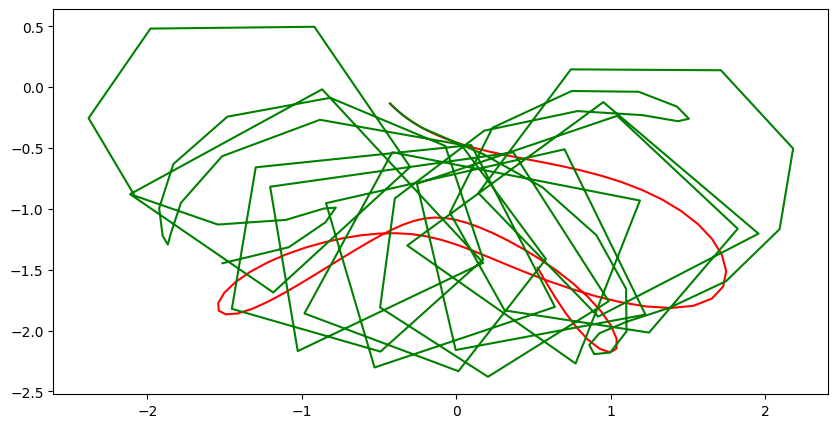

In [ ]:
sol, time = makepath(-20., 35.)
# sol2, time2= makepath(-50, 140)

OneStep(sol, time, filename, steps = 100)
# OneStep(sol2, time2, filename, steps = 100)

In [137]:
filename1 = 'lstm-pend2'
filename2 = 'pend_hc_order_2002_incr_conserv_energy.pth'
filename3 = 'pend_hc_order_2002_incr_lagrange.pth'